# Building Network Models

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

In previous sections, it has been illustrated how to define neuron models by `brainpy.NeuGroup` and synapse models by `brainpy.TwoEndConn`. This section will introduce `brainpy.Network`, which is the base class used to build network models.

## brainpy.Network

Different from `brainpy.NeuGroup` and `brainpy.TwoEndConn`, the use of `brainpy.Network` is simpler, because there is no pre-defined parameters in the inititialization function and no update function to implement. **The only requirement is to inherit the `brianpy.Network` base class.** Though not required, users are supposed to build the network with neuron and synapse models in the `__init__` function. 

Below is an example of building an excitation-inhibition (E-I) balanced network\[1\].

### Excitation-Inhibition (E-I) Balanced Network

The E-I balanced network was first proposed to explain the irregular firing patterns of cortical neurons and comfirmed by experimental data. THe network consists of excitatory (E) neurons and inhibitory (I) neurons, the ratio of which is about 4 : 1. The biggest difference between excitatory and inhibitory neurons is the reversal potential - the reversal potential of inhibitory neurons is much lower than that of excitatory neurons. Besides, the membrane time constant of inhibitory neurons is longer than that of excitatory neurons, which indicates that inhibitory neurons have slower dynamics.

The implementation of a E-I balanced network is as follows:

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

# BrianPy also contains some build-in conanical neuron and synapse models
LIF = bp.models.LIF
ExpCOBA = bp.models.ExpCOBA


class EINet(bp.Network):
  def __init__(self, num_exc, num_inh, method='exp_auto', **kwargs):
    super(EINet, self).__init__(**kwargs)

    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = LIF(num_exc, **pars, method=method)
    I = LIF(num_inh, **pars, method=method)
    E.V[:] = bp.math.random.randn(num_exc) * 2 - 55.
    I.V[:] = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    w_e = 0.6  # excitatory synaptic weight
    w_i = 6.7  # inhibitory synaptic weight
    E_pars = dict(E=0., g_max=w_e, tau=5.)
    I_pars = dict(E=-80., g_max=w_i, tau=10.)
    
    # Neurons connect to each other randomly with a connection probability of 2%
    self.E2E = ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.E2I = ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02), **E_pars, method=method)
    self.I2E = ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)
    self.I2I = ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02), **I_pars, method=method)

    self.E = E
    self.I = I

The building blocks, i.e. the neural groups and synapses are wrapped stored in the `EINet` class. Hereafter, the variables in these blocks can be monitored during simulation and displayed after simulation. 

### Building a network and Running a simulation

The `EINet` model can be instantiated as below:

In [2]:
net = EINet(3200, 800, method='exp_auto')  # method: the numerical integrator method

After construction, simulation can be performed:

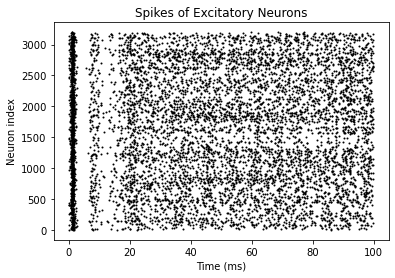

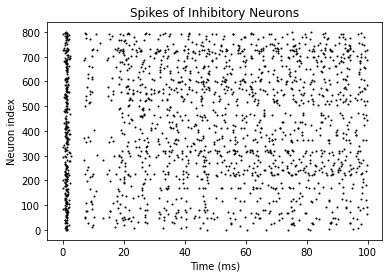

In [3]:
runner = bp.StructRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)])
t = runner.run(100.)

# visualization
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'],
                         title='Spikes of Excitatory Neurons', show=True)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'],
                         title='Spikes of Inhibitory Neurons', show=True)

### A Simplified way to build a network

Sometimes the network structure is relatively simple, and the network can be constructed without defining a network class. Instead, it can be constructed by using `brainpy.Network` directly. 

Below is the example in the section of [Building Synapse Models](building_synapse_models), in which the network consists of two LIF neural groups connected by exponential synapses.

In [4]:
# neural groups
pre_size = (8, 4)
post_size = 10
pre_neu = LIF(pre_size, tau=10, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)
post_neu = LIF(post_size, tau=20, V_th=-30, V_rest=-60, V_reset=-60, tau_ref=5.)

#synaptic connections
conn = bp.connect.All2All()
exp_syn = ExpCOBA(pre_neu, post_neu, conn, E=0., g_max=0.6, tau=5)

The simplified way to build a network is as follows:

In [7]:
simple_net = bp.Network(exp_syn, pre=pre_neu, post=post_neu)

The building blocks can be passed directly to `brainpy.Network` or received by other arguments. If an argument is given, the neuron or synapse model will named as the argument. This will affect the following dynamics analysis and will be discussed in greater detail in [Dynamics Simulation - Monitors and Inputs](../tutorial_simulation/monitors_and_inputs.ipynb).

After construction, the simulation goes the same way:

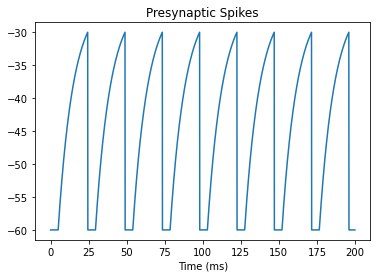

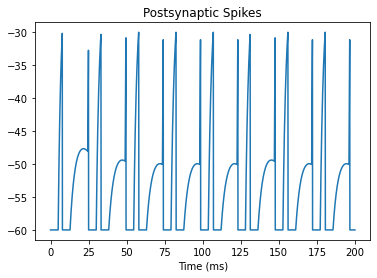

In [8]:
runner = bp.StructRunner(simple_net, monitors=['pre.V', 'post.V'], inputs=[('pre.input', 35.)])
runner.run(200)

bp.visualize.line_plot(runner.mon.ts, runner.mon['pre.V'], 
                       title='Presynaptic Spikes', show=True)
bp.visualize.line_plot(runner.mon.ts, runner.mon['post.V'], 
                       title='Postsynaptic Spikes', show=True)

Above are some simulation examples showing the possible application of network models. The detailed description of dynamics simulation is covered in [Dynamics Simulation](../tutorial_simulation/index.rst), where the use of monitors and inputs will be expatiated.

**References**: 

[1] Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98.